Esse notebook é uma tradução do [artigo](https://towardsdatascience.com/a-complete-machine-learning-project-walk-through-in-python-part-two-300f1f8147e2) originalmente escrito por [William Koehrsen](https://twitter.com/koehrsen_will) no site [Towards Data Science](https://towardsdatascience.com)

# Um projeto completo de aprendizado de máquina em Python - Parte 2

Montar todas as peças de aprendizado de máquina necessárias para resolver um problema pode ser uma tarefa assustadora. Nesta série de artigos, estamos caminhando para implementar um fluxo de trabalho de aprendizado de máquina usando um conjunto de dados do mundo real para ver como as técnicas individuais se juntam.

No primeiro [notebook](https://github.com/willsilvano/datascience/blob/master/Towards%20DataScience/Energy%20New%20York%20-%20Part%20One.ipynb), limpamos e estruturamos os dados, fizemos uma análise exploratória de dados, desenvolvemos um conjunto de features para usar em nosso modelo e estabelecemos uma linha de base em relação à qual podemos medir o desempenho. Neste artigo, veremos como implementar e comparar vários modelos de aprendizado de máquina no Python, executar o ajuste de hiperparâmetros para otimizar o melhor modelo e avaliar o modelo final no conjunto de testes.

# Imports

Abaixo estão as bibliotecas que serão utilizadas nesse notebook:

In [1]:
# Pandas e numpy para manipulação dos dados
import pandas as pd
import numpy as np

# Desativa alguns warnings
pd.options.mode.chained_assignment = None

# Altera o padrão do número de colunas exibidas pelo pandas para 60
pd.set_option('display.max_columns', 60)

# Matplotlib para visualização dos dados
import matplotlib.pyplot as plt
%matplotlib inline

# Altera o tamanho da fonte padrão
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn para visualização
import seaborn as sns
sns.set(font_scale = 2)

# Atribuição para valores faltantes e padrões de escala de valores
from sklearn.preprocessing import Imputer, MinMaxScaler

# Modelos de Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Hiperparâmetros
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Avaliação e Seleção de Modelos

Lembramos que estamos trabalhando em uma tarefa de regressão supervisionada: usando os [dados de energia de edifícios da cidade de Nova York](http://www.nyc.gov/html/gbee/html/plan/ll84_scores.shtml), queremos desenvolver um modelo que possa prever a pontuação [Energy Star](https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/interpret-your-results/what) de um edifício. Nosso foco está na precisão das previsões e interpretabilidade do modelo.

Há uma[ tonelada de modelos de aprendizado de máquina](http://scikit-learn.org/stable/supervised_learning.html) para escolher e decidir por onde começar pode ser intimidante. Embora existam [alguns gráficos](https://docs.microsoft.com/en-us/azure/machine-learning/studio/algorithm-cheat-sheet) que tentam mostrar qual algoritmo usar, prefiro apenas experimentar vários e ver qual deles funciona melhor! O aprendizado de máquina ainda é um campo impulsionado principalmente por [resultados empíricos (experimentais) e não teóricos](https://www.quora.com/How-much-of-deep-learning-research-is-empirical-versus-theoretical), e é quase impossível [saber com antecedência qual modelo fará o melhor](http://www.statsblogs.com/2014/01/25/machine-learning-lesson-of-the-day-the-no-free-lunch-theorem/).

Geralmente, é uma boa ideia começar com modelos simples e interpretáveis, como a regressão linear, e, se o desempenho não for adequado, passar para métodos mais complexos, mas geralmente mais precisos. O gráfico a seguir mostra uma versão (altamente não científica) da relação entre precisão e interpretabilidade:

![alt text](https://cdn-images-1.medium.com/max/800/1*NkffR5Ufy_h4RfSVpTJ2iQ.png)

Vamos avaliar cinco modelos diferentes cobrindo o espectro da complexidade:

- **Linear Regression**
- **K-Nearest Neighbors Regression**
- **Random Forest Regression**
- **Gradient Boosted Regression**
- **Support Vector Machine Regression**

Neste notebook, vamos nos concentrar na implementação desses métodos, em vez da teoria por trás deles. Para qualquer pessoa interessada em aprender a fundo, eu recomendo [Uma Introdução à Aprendizagem Estatística](http://www-bcf.usc.edu/~gareth/ISL/) (disponível on-line gratuito) ou o [Aprendizado de Máquina Prático com o Scikit-Learn e o TensorFlow](http://shop.oreilly.com/product/0636920052289.do). Ambos os livros didáticos fazem um ótimo trabalho explicando a teoria e mostrando como usar efetivamente os métodos em R e Python, respectivamente.

# Imputando Valores Ausentes

Embora tenhamos descartado as colunas com mais de 50% de valores ausentes quando limpamos os dados, ainda há algumas observações ausentes. Os modelos de aprendizado de máquina não podem lidar com quaisquer valores ausentes, então temos que preenchê-los, um [processo conhecido como imputação](https://en.wikipedia.org/wiki/Imputation_%28statistics%29).

Primeiro, lemos todos os dados que salvamos anteriormente:

In [2]:
# Cria novos dataframes com base nos arquivos salvos anteriormente
train_features = pd.read_csv('data/energy_new_york_training_features.csv')
train_labels = pd.read_csv('data/energy_new_york_training_labels.csv')

test_features = pd.read_csv('data/energy_new_york_testing_features.csv')
test_labels = pd.read_csv('data/energy_new_york_testing_labels.csv')

# Exibe o tamanho dos dataframes
print('Training Feature Size', train_features.shape)
print('Training Labels Size ', train_labels.shape)
print('Testing Feature Size ', test_features.shape)
print('Testing Labels Size  ', test_labels.shape)

Training Feature Size (6622, 65)
Training Labels Size  (6622, 1)
Testing Feature Size  (2839, 65)
Testing Labels Size   (2839, 1)


In [3]:
# Mosstra as 10 primeiras linhas do dataframe
train_features.head(10)

,Direct GHG Emissions (Metric Tons CO2e),Water Intensity (All Water Sources) (gal/ft²),log_Property Id,log_Year Built,log_Number of Buildings - Self-reported,log_Occupancy,log_Weather Normalized Site Natural Gas Use (therms),log_Direct GHG Emissions (Metric Tons CO2e),log_Property GFA - Self-Reported (ft²),log_Water Intensity (All Water Sources) (gal/ft²),log_Source EUI (kBtu/ft²),log_Community Board,log_Census Tract,Borough_Bronx,Borough_Brooklyn,Borough_Manhattan,Borough_Queens,Borough_Staten Island,Largest Property Use Type_Adult Education,Largest Property Use Type_Automobile Dealership,Largest Property Use Type_Bank Branch,Largest Property Use Type_College/University,Largest Property Use Type_Convenience Store without Gas Station,Largest Property Use Type_Courthouse,Largest Property Use Type_Distribution Center,Largest Property Use Type_Enclosed Mall,Largest Property Use Type_Financial Office,Largest Property Use Type_Hospital (General Medical & Surgical),Largest Property Use Type_Hotel,Largest Property Use Type_K-12 School,...,Largest Property Use Type_Museum,Largest Property Use Type_Non-Refrigerated Warehouse,Largest Property Use Type_Office,Largest Property Use Type_Other,Largest Property Use Type_Other - Education,Largest Property Use Type_Other - Entertainment/Public Assembly,Largest Property Use Type_Other - Lodging/Residential,Largest Property Use Type_Other - Mall,Largest Property Use Type_Other - Public Services,Largest Property Use Type_Other - Recreation,Largest Property Use Type_Other - Services,Largest Property Use Type_Other - Specialty Hospital,Largest Property Use Type_Outpatient Rehabilitation/Physical Therapy,Largest Property Use Type_Parking,Largest Property Use Type_Performing Arts,Largest Property Use Type_Pre-school/Daycare,Largest Property Use Type_Refrigerated Warehouse,"Largest Property Use Type_Repair Services (Vehicle, Shoe, Locksmith, etc.)",Largest Property Use Type_Residence Hall/Dormitory,Largest Property Use Type_Residential Care Facility,Largest Property Use Type_Restaurant,Largest Property Use Type_Retail Store,Largest Property Use Type_Self-Storage Facility,Largest Property Use Type_Senior Care Community,Largest Property Use Type_Social/Meeting Hall,Largest Property Use Type_Strip Mall,Largest Property Use Type_Supermarket/Grocery Store,Largest Property Use Type_Urgent Care/Clinic/Other Outpatient,Largest Property Use Type_Wholesale Club/Supercenter,Largest Property Use Type_Worship Facility
0,440.9,99.41,15.581915,7.575585,0.0,4.60517,11.429059,6.088818,11.255449,4.599253,5.143416,NaN,NaN,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,217.9,NaN,15.296761,7.563201,0.0,4.60517,10.708118,5.384036,10.858999,NaN,4.902307,1.098612,5.081404,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,151.0,NaN,15.355679,7.577634,0.0,4.60517,10.255492,5.017280,11.561716,NaN,4.254193,2.197225,5.796058,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,672.4,NaN,15.037325,7.596894,0.0,4.60517,11.823328,6.510853,11.770146,NaN,5.665388,0.000000,3.295837,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,456.5,28.65,14.810363,7.563720,0.0,4.60517,7.537217,6.123589,11.711366,3.355153,4.487512,1.945910,5.105945,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,248.8,4.80,14.703700,7.564757,0.0,4.49981,10.627995,5.516649,12.398963,1.568616,4.844187,0.693147,3.610918,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,227.3,67.14,15.562530,7.571474,0.0,4.60517,10.722937,5.426271,11.242428,4.206780,4.528289,2.484907,6.194405,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,431.4,30.73,14.797778,7.569412,0.0,4.60517,NaN,6.067036,11.609598,3.425239,4.809742,2.079442,4.95582

Cada valor que é `NaN` representa uma observação ausente. Embora haja [várias maneiras de preencher os dados ausentes](https://www.omicsonline.org/open-access/a-comparison-of-six-methods-for-missing-data-imputation-2155-6180-1000224.php?aid=54590), usaremos um método relativamente simples, a imputação mediana. Isso substitui todos os valores ausentes em uma coluna pelo valor mediano da coluna.

No código a seguir, criamos um objeto [Scikit-Learn](http://scikit-learn.org/stable/) `Imputer` com a estratégia definida como mediana. Em seguida, treinamos esse objeto nos dados de treinamento (usando `imputer.fit`) e o usamos para preencher os valores ausentes nos dados de treinamento e teste (usando `imputer.transform`). **Isso significa que os valores ausentes nos dados de teste são preenchidos com o valor mediano correspondente dos dados de treinamento**.

(Temos que fazer a imputação dessa maneira, em vez de treinar todos os dados para evitar o problema de [vazamento de dados de teste](https://www.kaggle.com/dansbecker/data-leakage), em que as informações do conjunto de dados de teste se espalham para os dados de treinamento.)


In [4]:
# Cria um imputer definido com estratégia para preenchimento com a mediana
imputer = Imputer(strategy='median')

# Treina o imputer com o dataframe de treinamento
imputer.fit(train_features)

# Transforma o conjunto de treinamento e teste conforme o imputer
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

In [5]:
print('Valores ausentes no conjunto de treinamento:', np.sum(np.isnan(X)))
print('Valores ausentes no conjunto de teste:', np.sum(np.isnan(X_test)))

Valores ausentes no conjunto de treinamento: 0
Valores ausentes no conjunto de teste: 0


In [6]:
# Verifica se todos os valores são finitos
print(np.where(~np.isfinite(X)))
print(np.where(~np.isfinite(X_test)))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


Após a imputação, todos as features estão com valores reais e finitos, sem valores ausentes. Para métodos mais sofisticados de imputação (embora os valores medianos usualmente funcionem bem) confira este [artigo](https://www.tandfonline.com/doi/full/10.1080/1743727X.2014.979146).

# Dimensionamento de features

[Dimensionamento](https://en.wikipedia.org/wiki/Feature_scaling) refere-se ao processo geral de alterar o intervalo de uma feature. [Isso é necessário](https://stats.stackexchange.com/questions/121886/when-should-i-apply-feature-scaling-for-my-data) porque as features são medidas em diferentes unidades e, portanto, cobrem diferentes faixas. Métodos como [SVM](https://stats.stackexchange.com/questions/305906/feature-scaling-in-svm-does-it-depend-on-the-kernel) e KNN que levam em consideração as medidas de distância entre observações são significativamente afetados pela faixa das features e aplicação de dimensionamento permite que eles aprendam. Embora métodos como [Regressão Linear e Floresta Aleatória](https://stats.stackexchange.com/questions/121886/when-should-i-apply-feature-scaling-for-my-data) não requeiram realmente o dimensionamento de features, ainda é recomendável seguir essa etapa quando estamos comparando vários algoritmos.

Vamos escalar as features colocando cada uma em um intervalo entre 0 e 1. Isso é feito tomando cada valor de uma feature, subtraindo o valor mínimo da feature e dividindo pelo máximo menos o mínimo (o intervalo). Essa versão específica do escalonamento é geralmente chamada de [normalização e a outra versão principal é conhecida como padronização](https://machinelearningmastery.com/normalize-standardize-machine-learning-data-weka/).

Enquanto este processo seria fácil de implementar manualmente, podemos fazê-lo usando um objeto `MinMaxScaler` no Scikit-Learn. O código para esse método é idêntico ao da imputação, exceto com um `scaler` em vez de `imputer`! Mais uma vez, nos certificamos de treinar apenas usando dados de treinamento e então transformamos todos os dados.

In [7]:
# Cria o objeto scaler com uma faixa de 0 a 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Treina o scaler com o conjunto de treino das features (já feito imput anteriorment)
scaler.fit(X)

# Transforma o conjunto de treino e teste
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [8]:
# Converte os dados de saída (score) para um array de uma dimensão (vetor)
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))

Cada feature agora tem um valor mínimo de 0 e um valor máximo de 1. A imputação de valor ausente e o dimensionamento de features são duas etapas necessárias em quase todos os `pipelines` de aprendizado de máquina, por isso é uma boa ideia entender como eles funcionam!

# Implementando Modelos de Aprendizado de Máquina no Scikit-Learn

Depois de todo o trabalho que passamos limpando e formatando os dados, criar, treinar e prever com os modelos é relativamente simples. Usaremos a [biblioteca Scikit-Learn](http://scikit-learn.org/stable/documentation.html) em Python, que possui ótima documentação e uma sintaxe consistente de construção de modelo. Depois de saber como criar um modelo no Scikit-Learn, você pode implementar rapidamente diversos algoritmos.

Abaixo serão criados alguns modelos, treinamento (usando `.fit`) e teste (usando `.predict`).

### Funções criadas para auxiliar nos algoritmos a seguir

In [9]:
# Calcula o erro absoluto médio (MAE)
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Treina e avalia o modelo e retorna a metrica do MAE
def fit_and_evaluate(model):
    
    # Treina o modelo
    model.fit(X, y)

    # Realiza as predições sobre o conjunto de teste
    predictions = model.predict(X_test)
    
    model_mae = mae(y_test, predictions)
    
    return model_mae

### Gradient Boosting Regressor

In [10]:
# Cria o modelo
gradient_boost = GradientBoostingRegressor(random_state=60)

# Treina, avalia e retorna o MAE
gradient_boost_mae = fit_and_evaluate(gradient_boost)

print('Desempenho de Gradient Boosted no conjunto de testes: MAE = %0.4f' % gradient_boost_mae)

Desempenho de Gradient Boosted no conjunto de testes: MAE = 9.2673


### Linear Regression

In [11]:
# Cria o modelo
lr = LinearRegression()

# Treina, avalia e retorna o MAE
lr_mae = fit_and_evaluate(lr)

print('Desempenho de LinearRegression no conjunto de testes: MAE = %0.4f' % lr_mae)

Desempenho de LinearRegression no conjunto de testes: MAE = 15.8081


### Support Vector Machine

In [12]:
# Cria o modelo
svm = SVR(C = 1000, gamma = 0.1)

# Treina, avalia e retorna o MAE
svm_mae = fit_and_evaluate(svm)

print('Desempenho de SVM no conjunto de testes: MAE = %0.4f' % svm_mae)

Desempenho de SVM no conjunto de testes: MAE = 12.5500


### Random Forest

In [13]:
# Cria o modelo
random_forest = RandomForestRegressor(random_state=60)

# Treina, avalia e retorna o MAE
random_forest_mae = fit_and_evaluate(random_forest)

print('Desempenho de Random Forest no conjunto de testes: MAE = %0.4f' % random_forest_mae)

Desempenho de Random Forest no conjunto de testes: MAE = 9.2217


### K-Nearest Neighbors (KNN)

In [14]:
# Cria o modelo
knn = KNeighborsRegressor(n_neighbors=10)

# Treina, avalia e retorna o MAE
knn_mae = fit_and_evaluate(knn)

print('Desempenho de KNN no conjunto de testes: MAE = %0.4f' % knn_mae)

Desempenho de KNN no conjunto de testes: MAE = 16.6020


A seguir iremos plotar um gráfico de barras comparando o valor de `MAE` de todos os modelos que avaliamos.

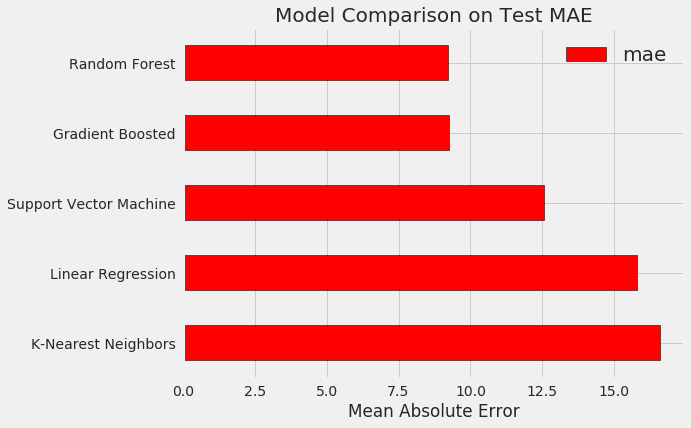

In [15]:
plt.style.use('fivethirtyeight')
figsize(8, 6)

# Dataframe com os resultados de cada modelo
model_comparison = pd.DataFrame({'model': ['Linear Regression', 'Support Vector Machine',
                                          'Random Forest', 'Gradient Boosted',
                                          'K-Nearest Neighbors'],
                                'mae': [lr_mae, svm_mae, random_forest_mae,
                                       gradient_boost_mae, knn_mae]})

# Gráfico de barra horizontal com os resultados MAE de cada modelo
model_comparison.sort_values('mae', ascending=False).plot(
    x='model', y='mae', kind='barh', color='red', edgecolor='black')

plt.ylabel('')
plt.xlabel('Mean Absolute Error')
plt.title('Model Comparison on Test MAE', size=20)
plt.yticks(size=14)
plt.xticks(size=14)
plt.show()

Para colocar esses números em perspectiva, a linha de base ingênua calculada usando o valor mediano do alvo foi de 24,5. Claramente, o aprendizado de máquina é aplicável ao nosso problema por causa da melhoria significativa em relação à linha de base!

O Random Forest (9.2217 MAE) bate levemente o [Gradient Boosted Regressor](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/) (MAE = 9.2673). Esses resultados não são totalmente justos porque estamos usando principalmente os valores padrão dos hiperparâmetros. [Especialmente em modelos como Support Vector Machine](http://pyml.sourceforge.net/doc/howto.pdf), o desempenho é altamente dependente dessas configurações. No entanto, a partir desses resultados, vamos selecionar o Gradient Boosted Regressor para otimização do modelo.

# Ajuste de hiperparâmetros para otimização de modelos

No aprendizado de máquina, depois de termos selecionado um modelo, podemos otimizá-lo para o nosso problema, ajustando os hiperparâmetros do modelo.

Primeiro, quais são os [hiperparâmetros e como eles diferem dos parâmetros](https://machinelearningmastery.com/difference-between-a-parameter-and-a-hyperparameter/)?

- Os **hiperparâmetros** do modelo são melhor considerados como configurações para um algoritmo de aprendizado de máquina que são definidos pelo cientista de dados antes do treinamento. Exemplos seriam o número de árvores em uma random forest ou o número de vizinhos usados no algoritmo K-nearest neighbors.


- Os **parâmetros** do modelo são o que o modelo aprende durante o treinamento, como pesos em uma regressão linear.

Controlar os hiperparâmetros afeta o desempenho do modelo, alterando o equilíbrio entre [underfitting e overfitting](https://towardsdatascience.com/overfitting-vs-underfitting-a-conceptual-explanation-d94ee20ca7f9) em um modelo. O underfitting é quando nosso modelo não é complexo o suficiente (ele não possui graus de liberdade suficientes) para aprender o mapeamento de features para o target. Um modelo de underfit tem [alto viés](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff), o que podemos corrigir tornando nosso modelo mais complexo.

Overfitting é quando nosso modelo essencialmente memoriza os dados de treinamento. Um modelo de overfit tem [alta variância](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff), que podemos corrigir limitando a complexidade do modelo por meio da regularização. Tanto um modelo de underfit quanto um overfit não serão capazes de generalizar bem os dados de teste.

O problema com a escolha dos hiperparâmetros certos é que o conjunto ideal será diferente para cada problema de aprendizado de máquina! Portanto, a única maneira de encontrar as melhores configurações é testar várias delas em cada novo conjunto de dados. Felizmente, o Scikit-Learn tem vários métodos que nos permitem avaliar com eficiência os hiperparâmetros. Além disso, projetos como o [TPOT do Epistasis Lab](https://epistasislab.github.io/tpot/) estão tentando otimizar a busca por hiperparâmetros usando métodos como [programação genética](https://en.wikipedia.org/wiki/Genetic_programming). Neste projeto, vamos continuar fazendo isso com o Scikit-Learn, mas continuamos ligados para mais trabalhos na cena auto-ML!

# Pesquisa aleatória com validação cruzada

O método específico de ajuste de hiperparâmetros que implementaremos é chamado de pesquisa aleatória com validação cruzada:

- **[Pesquisa aleatória](https://en.wikipedia.org/wiki/Hyperparameter_optimization#Random_search)** refere-se à técnica que usaremos para selecionar hiperparâmetros. Definimos uma grade e, em seguida, amostramos aleatoriamente diferentes combinações, em vez de pesquisar em grade, onde exaustivamente experimentamos todas as combinações. (Surpreendentemente, [a pesquisa aleatória executa quase tão bem quanto a pesquisa de grade](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf) com uma redução drástica no tempo de execução).


- **[Validação cruzada](https://www.openml.org/a/estimation-procedures/1)** é a técnica que usamos para avaliar uma combinação selecionada de hiperparâmetros. Em vez de dividir o treinamento em conjuntos de treinamento e validação separados, o que reduz a quantidade de dados de treinamento que podemos usar, usamos a Validação Cruzada de K-fold. Isso envolve dividir os dados de treinamento em K folds e depois passar por um processo iterativo em que primeiro treinamos o fold K-1 e depois avaliamos o desempenho do fold Kth. Repetimos este processo K vezes e no final da validação cruzada de K, tomamos o erro médio em cada uma das K iterações como a medida final de desempenho.

A ideia da validação cruzada K-Fold com K = 5 é mostrada abaixo:

![alt text](https://cdn-images-1.medium.com/max/800/1*rgba1BIOUys7wQcXcL4U5A.png)

Todo o processo de realização de pesquisa aleatória com validação cruzada é:

1. Configurar uma grade de hiperparâmetros para avaliar
2. Amostra aleatória de uma combinação de hiperparâmetros
3. Criar um modelo com a combinação selecionada
4. Avaliar o modelo usando validação cruzada K-fold
5. Decidir quais hiperparâmetros funcionaram melhor

Claro, nós não fazemos isso manualmente, mas deixamos que o `RandomizedSearchCV` do Scikit-Learn cuide de todo o trabalho!